### Setup and Dependency Installation

In [43]:
# ==============================
# 📦 SETUP & DEPENDENCY LOADING
# ==============================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
# ==== Environment & System Utilities ====
import os
import re
import json
import time
import random
import warnings
from collections import Counter


from transformers import AutoTokenizer, pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Suppress selected sklearn warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# ==== Data Manipulation ====
import numpy as np
import pandas as pd

# Configure pandas display options for better readability
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)

# ==== Visualization Tools ====
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display, Markdown, HTML

# Customize visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# ==== Text Preprocessing ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Ensure required NLTK resources are available
print("🔧 Initializing NLTK resources...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load Indonesian stopwords
stop_words = set(stopwords.words('indonesian'))

# ==== Traditional Machine Learning & Evaluation ====
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from sklearn.cluster import KMeans

# ==== Deep Learning & Transformer Models ====
import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, pipeline,
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    XLNetTokenizer, XLNetForSequenceClassification
)

# ==== External APIs (Google & Gemini) ====
from googleapiclient.discovery import build
import google.generativeai as genai

# ==== Progress Monitoring ====
from tqdm.notebook import tqdm

print("✅ All dependencies and environment configurations loaded successfully.")

🔧 Initializing NLTK resources...
✅ All dependencies and environment configurations loaded successfully.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rizky28eka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Environment Setup and Configuration

In [26]:
# ====================================
# 🌐 ENVIRONMENT SETUP & CONFIGURATION
# ====================================

# ==== Load Environment Variables ====
import os
from dotenv import load_dotenv
import google.generativeai as genai

# Load variables from .env file
load_dotenv()


# ==== Gemini API Configuration ====
def load_gemini_models():
    """
    Load and initialize multiple Gemini models using API keys from environment variables.
    """
    gemini_keys = [
        value for key, value in os.environ.items()
        if key.startswith("GEMINI_API_KEY_") and value.strip()
    ]

    # Prompt for manual input if no keys found
    if not gemini_keys:
        print("⚠️ No Gemini API keys found in environment. Please enter them manually:")
        gemini_keys = [
            input(f"🔑 Enter Gemini API Key #{i+1}: ").strip()
            for i in range(5)
        ]

    models = []
    for idx, key in enumerate(gemini_keys):
        try:
            genai.configure(api_key=key)
            model = genai.GenerativeModel("gemini-2.0-flash")
            models.append(model)
            print(f"✅ Gemini model #{idx+1} initialized successfully.")
        except Exception as e:
            print(f"❌ Failed to initialize Gemini model #{idx+1}: {e}")

    if not models:
        raise RuntimeError("❌ No valid Gemini models initialized. Please check your API keys.")

    return models

# Load Gemini models
gemini_models = load_gemini_models()
gemini_model = gemini_models[0]  # Default model


# ==== YouTube API Configuration ====
def get_youtube_api_key():
    """
    Retrieve YouTube API key from environment or prompt user input.
    """
    key = os.getenv("YOUTUBE_API_KEY", "").strip()
    if not key:
        key = input("🔑 Enter your YouTube API Key: ").strip()
    if not key:
        raise ValueError("❌ YouTube API Key is required.")
    return key

YOUTUBE_API_KEY = get_youtube_api_key()


# ==== YouTube Video ID Configuration ====
def get_video_id():
    """
    Retrieve target YouTube video ID from environment or prompt user input.
    """
    video_id = os.getenv("VIDEO_ID", "").strip()
    if not video_id:
        video_id = input("🎥 Enter the YouTube Video ID: ").strip()
    if not video_id:
        raise ValueError("❌ YouTube Video ID is required.")
    return video_id

VIDEO_ID = get_video_id()


# ==== Output Directory Configuration ====
def prepare_output_dirs(base_path="./output"):
    """
    Create structured output directories if they do not exist.
    """
    dirs = {
        "base": base_path,
        "comments": os.path.join(base_path, "comments"),
        "analysis": os.path.join(base_path, "analysis"),
        "visualizations": os.path.join(base_path, "visualizations")
    }
    for path in dirs.values():
        os.makedirs(path, exist_ok=True)
    return dirs

output_paths = prepare_output_dirs()


# ==== Configuration Summary ====
print("\n✅ Environment successfully configured.")
print(f"🎥 Video ID for analysis      : {VIDEO_ID}")
print(f"📁 Output base directory      : {output_paths['base']}")
print(f"📂 Comments directory         : {output_paths['comments']}")
print(f"📂 Analysis directory         : {output_paths['analysis']}")
print(f"📂 Visualizations directory   : {output_paths['visualizations']}")

✅ Gemini model #1 initialized successfully.
✅ Gemini model #2 initialized successfully.
✅ Gemini model #3 initialized successfully.
✅ Gemini model #4 initialized successfully.
✅ Gemini model #5 initialized successfully.

✅ Environment successfully configured.
🎥 Video ID for analysis      : -WLpXmnBmxo
📁 Output base directory      : ./output
📂 Comments directory         : ./output/comments
📂 Analysis directory         : ./output/analysis
📂 Visualizations directory   : ./output/visualizations


### YouTube Comments Collection

In [27]:
# ====================================
# 💬 YOUTUBE COMMENTS COLLECTION
# ====================================
from googleapiclient.discovery import build
from tqdm.notebook import tqdm
import pandas as pd
import os
from IPython.display import display, Markdown

# ==== Fetch YouTube Comments ====
def fetch_youtube_comments(video_id, api_key, max_results=100):
    """
    Retrieve all top-level YouTube comments from a given video using the YouTube Data API.

    Parameters:
        video_id (str): The ID of the YouTube video to fetch comments from.
        api_key (str): A valid YouTube Data API v3 key.
        max_results (int): Number of comments per API call (default 100).

    Returns:
        List[dict]: A list of dictionaries containing comment metadata.
    """
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments_data = []

    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=max_results,
            textFormat="plainText"
        )

        print("🔍 Fetching comments from YouTube API...")
        pbar = tqdm(desc="Collecting comments", unit="comments")

        while request:
            response = request.execute()
            for item in response.get('items', []):
                snippet = item['snippet']['topLevelComment']['snippet']
                comments_data.append({
                    "comment_id": item.get("id", ""),
                    "text": snippet.get("textDisplay", ""),
                    "author": snippet.get("authorDisplayName", ""),
                    "published_at": snippet.get("publishedAt", ""),
                    "like_count": snippet.get("likeCount", 0),
                })
                pbar.update(1)

            request = youtube.commentThreads().list_next(request, response)

        pbar.close()
        print(f"✅ Successfully retrieved {len(comments_data)} comments.")
        return comments_data

    except Exception as e:
        print(f"❌ Error during comment fetching: {e}")
        return []

# ==== Save Comments to CSV ====
def save_comments_to_csv(comments_data, output_dir, filename="raw_comments.csv"):
    """
    Save comment data to a CSV file for further processing.

    Parameters:
        comments_data (List[dict]): List of comment metadata dictionaries.
        output_dir (str): Path to the directory for saving the CSV.
        filename (str): Name of the output CSV file (default: raw_comments.csv).

    Returns:
        str: Full path to the saved CSV file.
    """
    os.makedirs(output_dir, exist_ok=True)
    df_comments = pd.DataFrame(comments_data)
    output_path = os.path.join(output_dir, filename)
    df_comments.to_csv(output_path, index=False)
    print(f"💾 Comments saved to: {output_path}")
    return output_path


# ==== Run Comment Collection ====
print("\n🔄 Starting comment collection process...")
comments_data = fetch_youtube_comments(VIDEO_ID, YOUTUBE_API_KEY)

if comments_data:
    print("\n📊 Comment Collection Summary:")
    print(f"🧾 Total comments collected: {len(comments_data)}")

    display(Markdown("### 📝 Sample of Collected Comments"))
    df_comments = pd.DataFrame(comments_data)
    display(df_comments.head())

    # Save to CSV
    raw_data_path = save_comments_to_csv(comments_data, output_paths["comments"])

else:
    print("⚠️ No comments collected. Please verify your Video ID and API Key.")


🔄 Starting comment collection process...
🔍 Fetching comments from YouTube API...


✅ Successfully retrieved 10401 comments.

📊 Comment Collection Summary:
🧾 Total comments collected: 10401


### 📝 Sample of Collected Comments

,comment_id,text,author,published_at,like_count
0,UgxjYX04V6EjtioNoW54AaABAg,"Dari pandangan saya dan pendapat pribadi saya presiden ini dia gak liat fakta di lapangan , beli...",@fahreeladjie2738,2025-05-07T10:56:28Z,0
1,UgxoLv9oxg7hm8aU5WN4AaABAg,"Baru aja ngeklik, udh ngantuk aja",@HaikalrfD8,2025-05-07T09:53:36Z,1
2,Ugxc-7twJcEt_L7Zk1V4AaABAg,"Kan emg dri awal beliu bisanya kerja nyata, g bisa omon2. Awokwowk kerja nyatanya apa bjir",@bayunyakak,2025-05-07T09:20:09Z,0
3,Ugxxwu0XqvMMMlxYHu94AaABAg,"Br sanggup melihat video ini, setelahnya bnr2 merasa yakin melihat bahwa Indonesia memang gelap....",@Rips-r1y,2025-05-06T23:57:42Z,0
4,UgxPm3D4TKuqbj3aSVx4AaABAg,Rakyat Bener 2 nggak Salah Pilih Punya Presiden Seperti PK Prabowo Tegas Berwibawa Dan Benar 2 B...,@jandabaru-l4y,2025-05-06T22:43:08Z,0


💾 Comments saved to: ./output/comments/raw_comments.csv


### Data Preprocessing and Cleaning

### 🔍 Missing Value Analysis

,Missing,Percentage (%)
comment_id,0,0.0
text,0,0.0
author,0,0.0
published_at,0,0.0
like_count,0,0.0


🧹 Cleaning comment texts...
⚠️ Removing 193 comments that became empty after cleaning.


### 📊 Comment Length Statistics

,original_length,cleaned_length,word_count
count,10208.000000,10208.000000,10208.000000
mean,116.734326,107.302116,16.055349
std,178.342929,167.029643,24.182116
min,3.000000,3.000000,1.000000
25%,33.000000,29.000000,5.000000
50%,66.000000,60.000000,9.000000
75%,134.000000,123.000000,18.000000
max,5856.000000,5639.000000,814.000000



🧵 Shortest Cleaned Comment:
hah

📏 Longest Cleaned Comment:
saya nonton full jam dan saya salut dengan pak presiden yang mau membuat acara seperti ini mau untuk dihajar dengan berbagai pertanyan kritis yang tidak bisa kita tebak atau bahkan menakutkan untuk dijawab pertanyaan yang seharusnya tidak dijawab oleh satu orang saja namun ternyata beliau bisa menjwabnya semuanya dari berbagai bidang kesehatan ekonomi hubungan internasional kebijakan publik hukum bahkan pertanyaaan ini tidak direncanakan sebelumnya respect juga bahwa beliau mau mengakui bebagai kekurangan dari pemerintahan yang pimpin namun sebagai kepala negara beliau tetap terus optimis untuk membawa negara ini untuk terus maju menurut saya pribadi semangat ini memang harus dimiliki oleh seorang kepala negara simbol nasional yang akan slealu dipandang oleh negara lain dan sebagai tanggung jawabnya menanggung jutaan masyarakat yang bawa dari setiap jawaban yang disampaikan kita bisa nilai bahwa pak prabowo punya pandangan gl

### 🧪 Sample of Cleaned Comments

,text,cleaned_text,word_count
5153,Waduh bagaimana ini Presiden di tanya kok jawabnya Iya kan iya kan gak runtut sepertnya gak s...,waduh bagaimana ini presiden tanya kok jawabnya iya kan iya kan gak runtut sepertnya gak siap ma...,29
2459,BUKAN TIDAK BANGGA TERHADAP PEMIMPIN REPUBLIK INI TETAP DISKUSII INI KELASNYA SEPERTI RAPAT KEPA...,bukan tidak bangga terhadap pemimpin republik ini tetap diskusii ini kelasnya seperti rapat kepa...,15
9655,"Berantas Korupsi, wujudkan segera UU perampasan aset koruptor dan hukuman yang berat untuk merek...",berantas korupsi wujudkan segera perampasan aset koruptor dan hukuman yang berat untuk mereka da...,24
8867,Pak prabowo kelihatan tidak banyak tau apa yang terjadi di bawahannya terutama di masyarakat,pak prabowo kelihatan tidak banyak tau apa yang terjadi bawahannya terutama masyarakat,12
9248,kecepatan nya di 1.5x aja kali ya biar dapat point nya,kecepatan nya aja kali biar dapat point nya,8


### 📊 Histogram: Original vs Cleaned Length

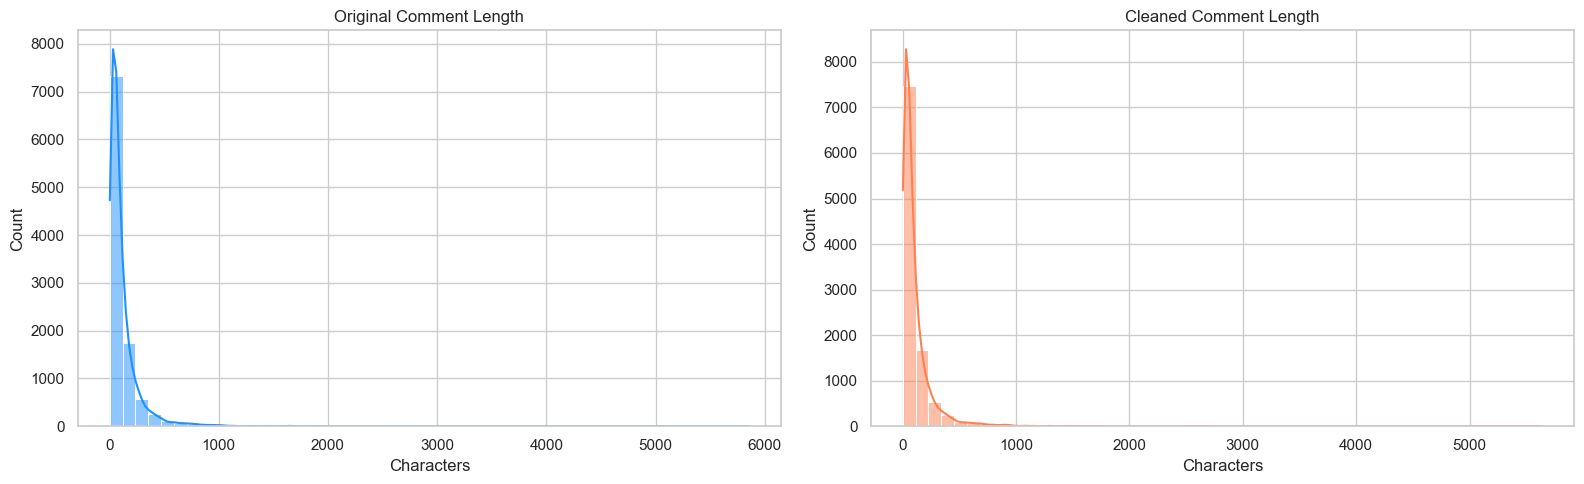

📷 Histogram saved to: output/visualizations/comment_length_histogram.png


### 📉 Word Count Distribution

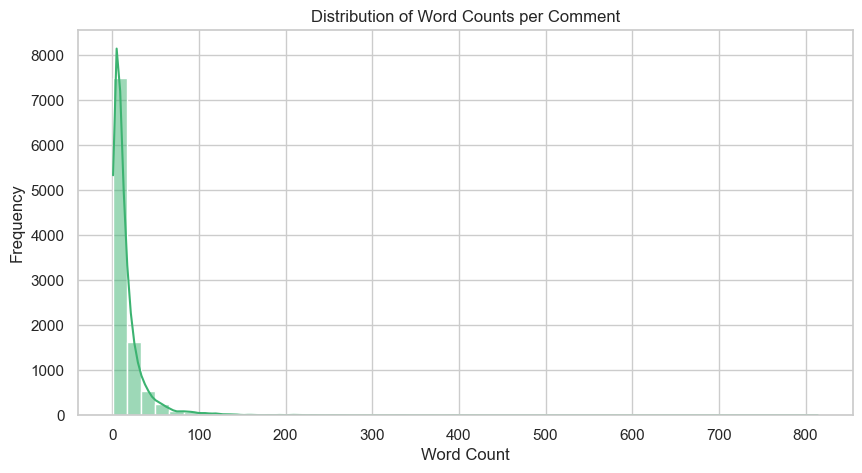

📷 Word Count Distribution saved to: output/visualizations/word_count_distribution.png


### ☁️ Word Cloud of Cleaned Comments

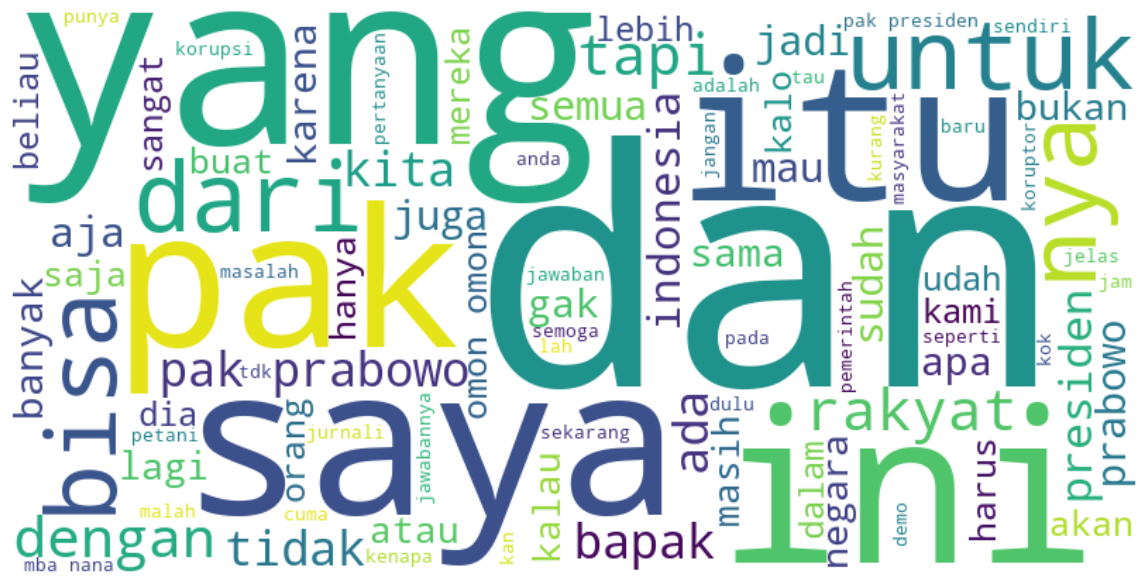

📷 Word Cloud saved to: output/visualizations/wordcloud_cleaned_comments.png


In [28]:
# ====================================
# 🧹 DATA PREPROCESSING & CLEANING
# ====================================
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# ==== STOPWORDS ====
stop_words = set(stopwords.words('english'))

# ==== MISSING VALUE ANALYSIS ====
display(Markdown("### 🔍 Missing Value Analysis"))
missing = df_comments.isnull().sum()
missing_pct = (missing / len(df_comments)) * 100
display(pd.DataFrame({'Missing': missing, 'Percentage (%)': missing_pct.round(2)}))

if df_comments['text'].isnull().sum() > 0:
    removed = df_comments['text'].isnull().sum()
    print(f"⚠️ Removing {removed} comments with missing text.")
    df_comments = df_comments.dropna(subset=['text'])

# ==== CLEANING FUNCTION ====
def clean_text(text):
    """
    Cleans text by:
    - Lowercasing
    - Removing emojis, HTML tags, URLs, non-alphabetic chars
    - Removing stopwords and short words
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return " ".join(tokens)

# ==== CLEANING TEXT ====
print("🧹 Cleaning comment texts...")
df_comments["cleaned_text"] = df_comments["text"].apply(clean_text)

# ==== REMOVE EMPTY CLEANED ====
empty_cleaned = df_comments["cleaned_text"].str.strip() == ""
print(f"⚠️ Removing {empty_cleaned.sum()} comments that became empty after cleaning.")
df_comments = df_comments[~empty_cleaned]

# ==== TEXT FEATURES ====
df_comments["original_length"] = df_comments["text"].apply(len)
df_comments["cleaned_length"] = df_comments["cleaned_text"].apply(len)
df_comments["word_count"] = df_comments["cleaned_text"].apply(lambda x: len(x.split()))

# ==== STATISTICS ====
display(Markdown("### 📊 Comment Length Statistics"))
display(df_comments[["original_length", "cleaned_length", "word_count"]].describe())

# ==== EXTREME CASES ====
shortest = df_comments.loc[df_comments["cleaned_length"].idxmin()]
longest = df_comments.loc[df_comments["cleaned_length"].idxmax()]
print("\n🧵 Shortest Cleaned Comment:")
print(shortest["cleaned_text"])
print("\n📏 Longest Cleaned Comment:")
print(longest["cleaned_text"])

# ==== SAVE CLEANED DATA ====
preprocessed_path = "output/analysis/preprocessed_comments.csv"
df_comments.to_csv(preprocessed_path, index=False, encoding="utf-8-sig")
print(f"💾 Preprocessed comments saved to: {preprocessed_path}")

# ==== SAMPLE OUTPUT ====
display(Markdown("### 🧪 Sample of Cleaned Comments"))
sample = df_comments[["text", "cleaned_text", "word_count"]].sample(5, random_state=42)
display(sample)

# ==== VISUALIZATION SETTINGS ====
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# ==== HISTOGRAM: LENGTH ====
display(Markdown("### 📊 Histogram: Original vs Cleaned Length"))
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df_comments["original_length"], bins=50, kde=True, ax=axs[0], color="dodgerblue")
axs[0].set_title("Original Comment Length")
axs[0].set_xlabel("Characters")

sns.histplot(df_comments["cleaned_length"], bins=50, kde=True, ax=axs[1], color="coral")
axs[1].set_title("Cleaned Comment Length")
axs[1].set_xlabel("Characters")

plt.tight_layout()
hist_path = "output/visualizations/comment_length_histogram.png"
plt.savefig(hist_path)
plt.show()
print(f"📷 Histogram saved to: {hist_path}")

# ==== HISTOGRAM: WORD COUNT ====
display(Markdown("### 📉 Word Count Distribution"))
plt.figure(figsize=(10, 5))
sns.histplot(df_comments["word_count"], bins=50, kde=True, color="mediumseagreen")
plt.title("Distribution of Word Counts per Comment")
plt.xlabel("Word Count")
plt.ylabel("Frequency")

wordcount_path = "output/visualizations/word_count_distribution.png"
plt.savefig(wordcount_path)
plt.show()
print(f"📷 Word Count Distribution saved to: {wordcount_path}")

# ==== WORD CLOUD ====
display(Markdown("### ☁️ Word Cloud of Cleaned Comments"))
all_text = " ".join(df_comments["cleaned_text"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white",
                      colormap="viridis", max_words=200, min_font_size=10).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()

wordcloud_path = "output/visualizations/wordcloud_cleaned_comments.png"
plt.savefig(wordcloud_path)
plt.show()
print(f"📷 Word Cloud saved to: {wordcloud_path}")


### Exploratory Data Analysis (EDA)

### 📏 Distribution & Boxplot: Word Count and Comment Length

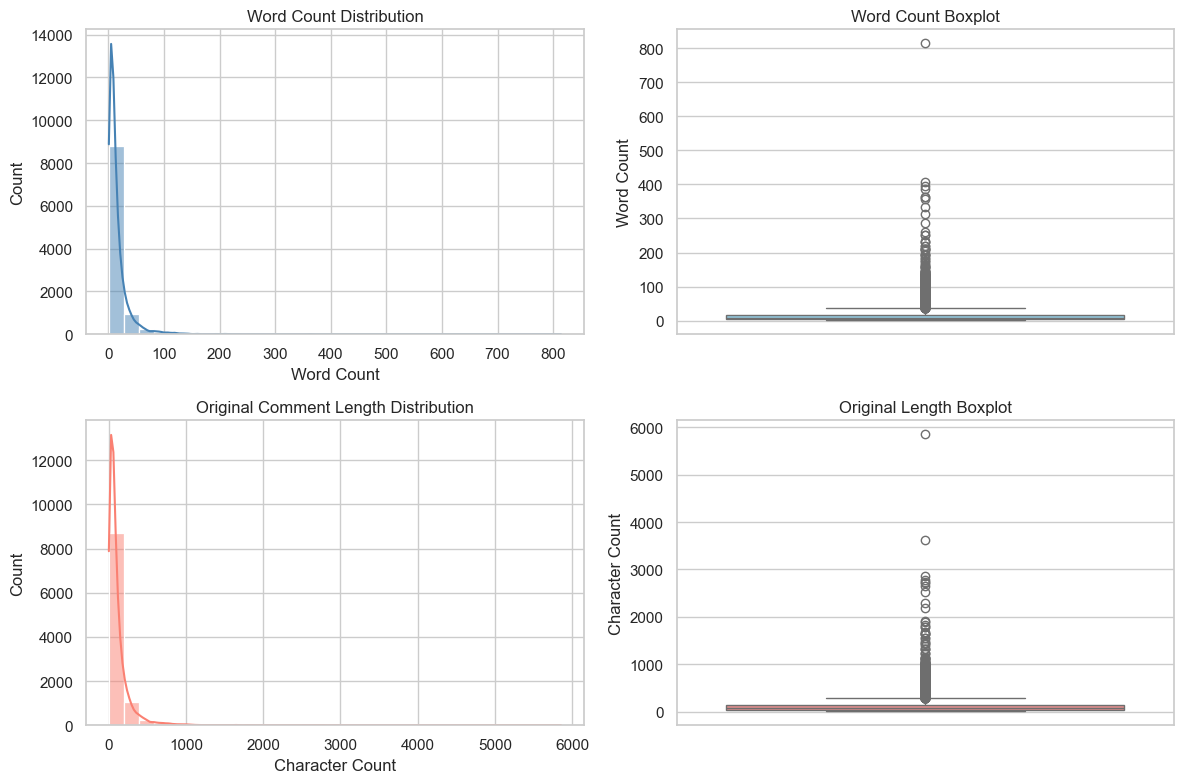

📷 Saved to: output/visualizations/comment_length_distribution.png


### 🚨 Outlier Detection in Word Count

🔎 Detected 901 outliers (8.83%)


#### ✨ Sample Outlier Comments

,text,word_count
8180,"Saya nonton full 3 jam dan saya salut dengan Pak Presiden yang mau membuat acara seperti ini, ma...",814
7222,Ini adalah ringkasan yang dibuat oleh AI. Mungkin ada ketidakakuratan.\n\nDurasi 00:00:00 - 01:0...,406
7178,"Rekomendasi nonton minimal 1,5x\r\n\r\n28:40 P1 Alfito Deannova (DetikCom)\r\n\r\n29:17 Mulai Ja...",395
4129,Terimakasih Pak Prabowo. Setelah menyimak video ini saya akan semakin bersemangat bekerja untuk ...,387
9175,"pertanyaan 150 hari pencapaian:\nawal-awal tidak dicatat.\n\n9:07: ""saya laksanakan keyakinan sa...",363


### 🕒 Temporal Analysis of Comment Activity

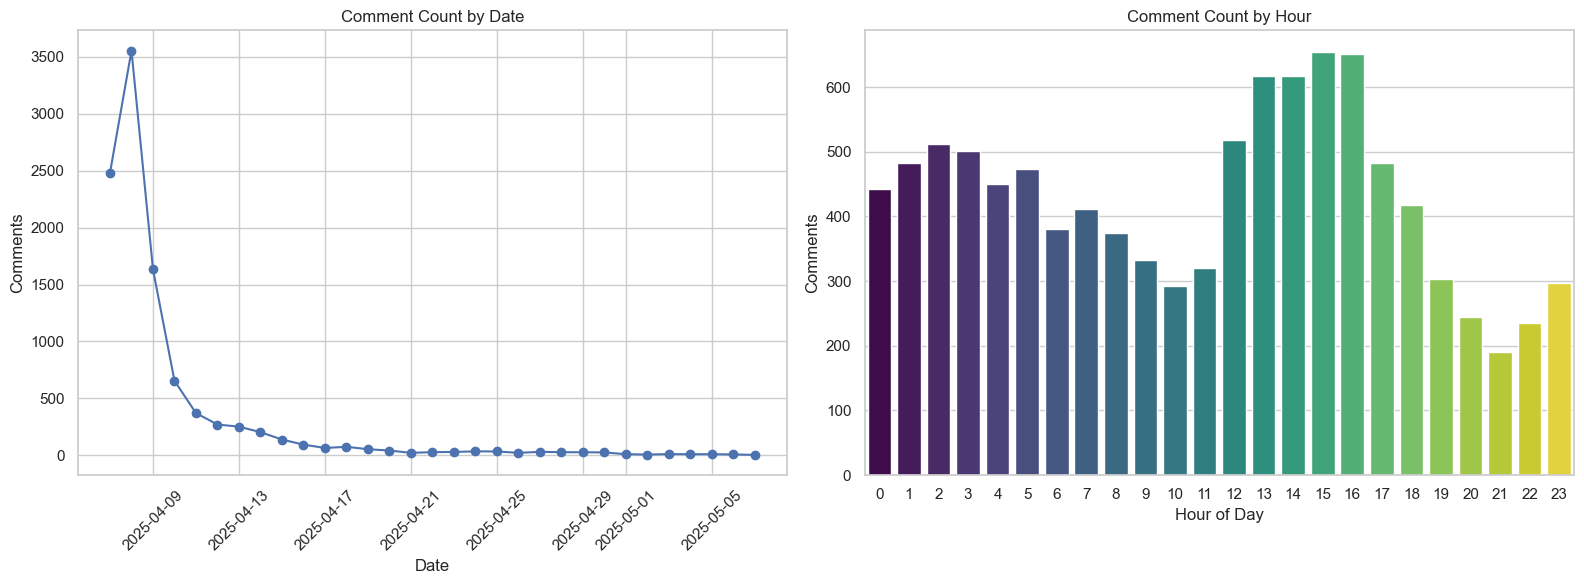

📷 Saved to: output/visualizations/comment_publication_time.png


### ❤️ Like Count Distribution

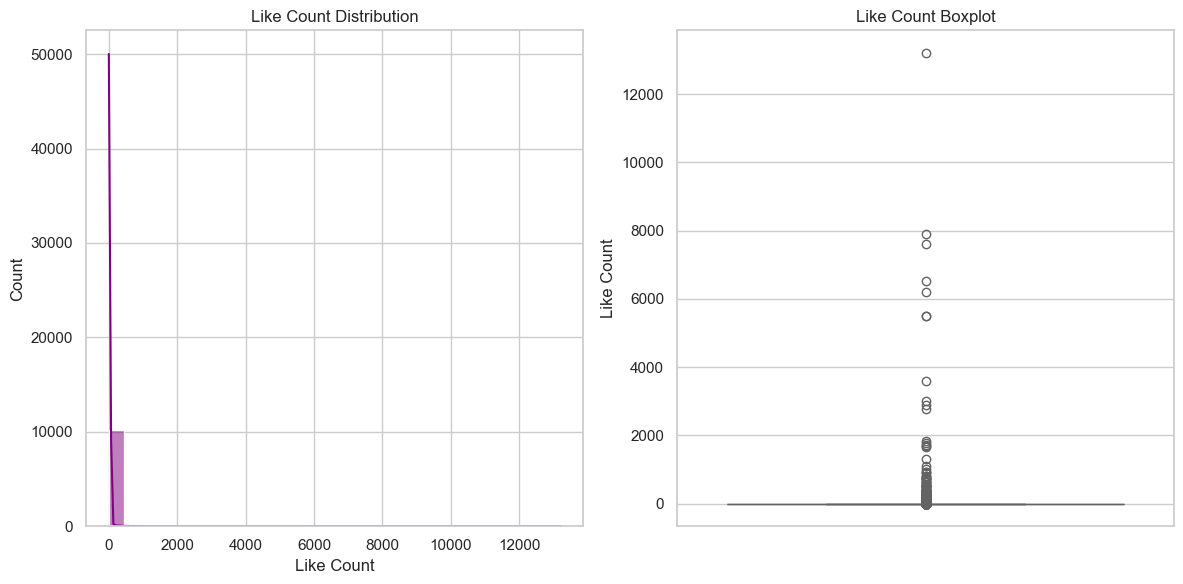

📷 Saved to: output/visualizations/like_count_distribution.png


### ⭐ Top 5 Most Liked Comments

,text,like_count,author
5057,"Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih ...",13209,@033_MUHAMMADARBYRAMADHAN
7931,"Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tid...",7917,@dhimasputratama631
9364,1) *GANTI MENTERI2 KORUP*\n2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*\n3) *BATALKAN UU PERAMPASAN ...,7596,@sofyanudin
7115,"Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu is...",6513,@Xui_Ana
6571,"Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, bia...",6206,@avichabastiansr5623


### 🧠 Top 20 Most Common Words

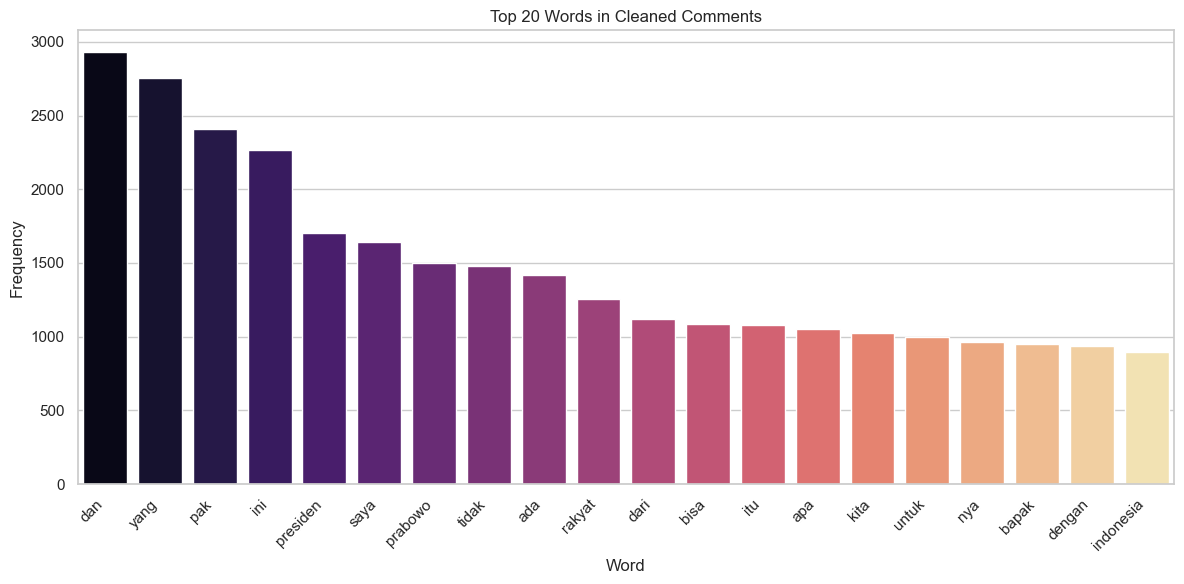

📷 Saved to: output/visualizations/common_words.png


### ☁️ Word Cloud of Cleaned Comments

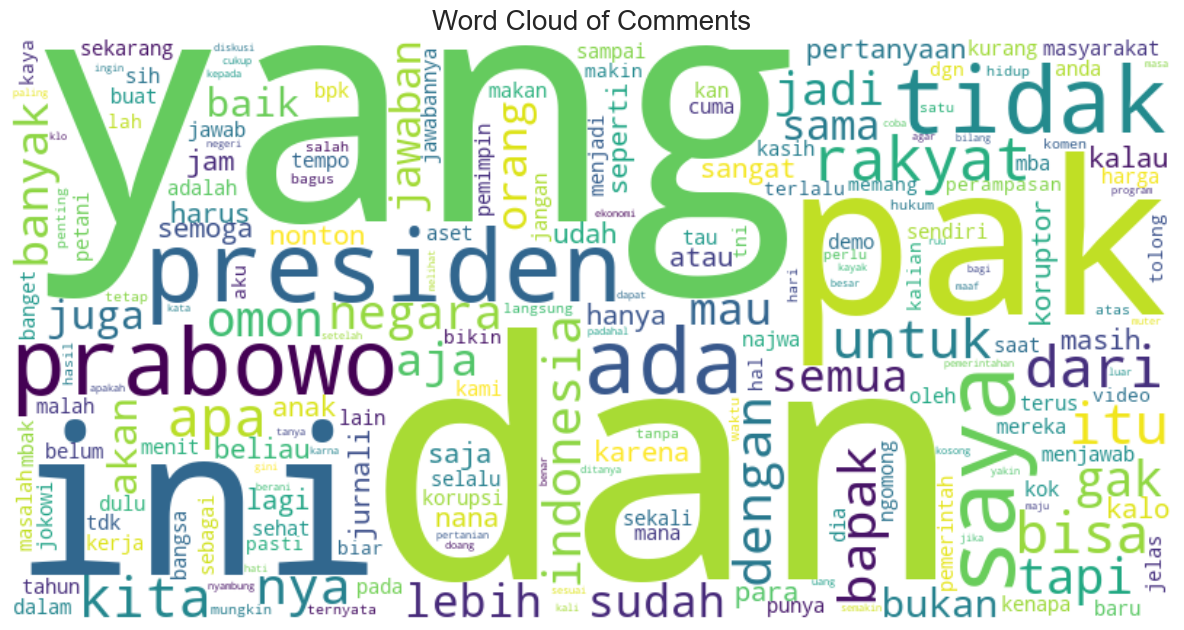

📷 Saved to: output/visualizations/wordcloud.png


### 🔗 Correlation Analysis Between Numeric Features

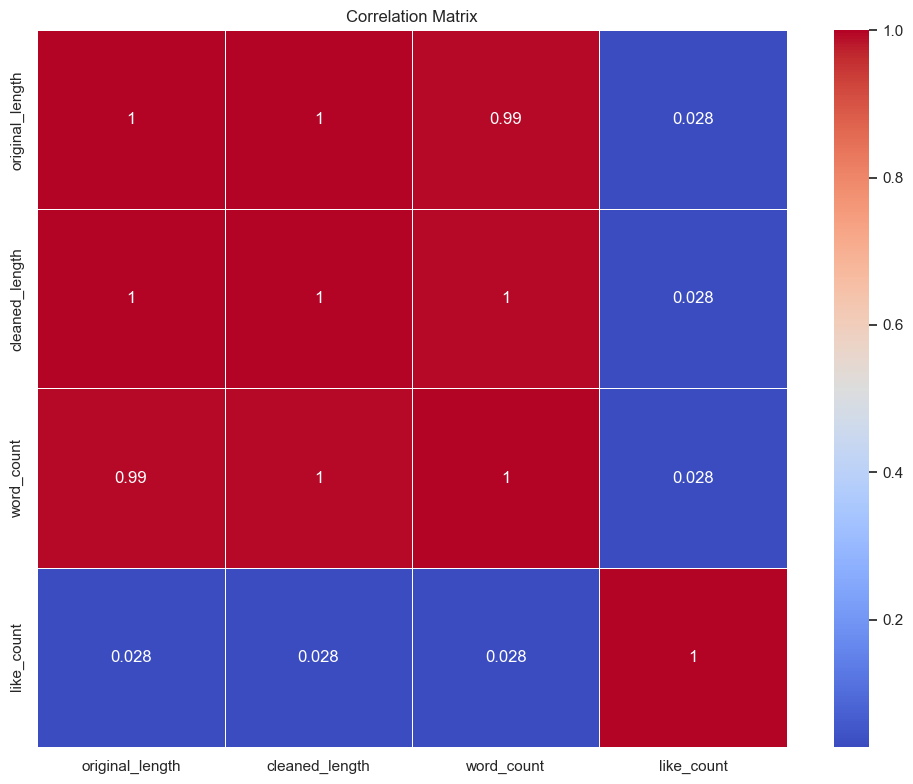

📷 Saved to: output/visualizations/correlation_matrix.png


### 📌 EDA Summary

📊 Total Comments: 10208
📊 Average Word Count: 16.055348746081506
📊 Median Word Count: 9.0
📊 Maximum Word Count: 814
📊 Average Like Count: 11.626175548589341
📊 Total Likes: 118680
📊 Most Common Words: ['dan', 'yang', 'pak', 'ini', 'presiden', 'saya', 'prabowo', 'tidak', 'ada', 'rakyat']
📊 Outlier Comments: 901
📊 Most Active Date: 2025-04-08
📊 Most Active Hour: 15


In [29]:
# ==== DISTRIBUSI WORD COUNT & COMMENT LENGTH ====
display(Markdown("### 📏 Distribution & Boxplot: Word Count and Comment Length"))

plt.figure(figsize=(12, 8))

# Word count distribution
plt.subplot(2, 2, 1)
sns.histplot(df_comments["word_count"], kde=True, bins=30, color="steelblue")
plt.title("Word Count Distribution")
plt.xlabel("Word Count")

# Word count boxplot
plt.subplot(2, 2, 2)
sns.boxplot(y=df_comments["word_count"], color="skyblue")
plt.title("Word Count Boxplot")
plt.ylabel("Word Count")

# Original comment length distribution
plt.subplot(2, 2, 3)
sns.histplot(df_comments["original_length"], kde=True, bins=30, color="salmon")
plt.title("Original Comment Length Distribution")
plt.xlabel("Character Count")

# Original comment length boxplot
plt.subplot(2, 2, 4)
sns.boxplot(y=df_comments["original_length"], color="lightcoral")
plt.title("Original Length Boxplot")
plt.ylabel("Character Count")

plt.tight_layout()
dist_path = "output/visualizations/comment_length_distribution.png"
plt.savefig(dist_path)
plt.show()
print(f"📷 Saved to: {dist_path}")

# ==== OUTLIER DETECTION ====
display(Markdown("### 🚨 Outlier Detection in Word Count"))

Q1 = df_comments["word_count"].quantile(0.25)
Q3 = df_comments["word_count"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df_comments[(df_comments["word_count"] < lower) | (df_comments["word_count"] > upper)]
outlier_percentage = len(outliers) / len(df_comments) * 100

# Outlier detection result
print(f"🔎 Detected {len(outliers)} outliers ({outlier_percentage:.2f}%)")

if not outliers.empty:
    display(Markdown("#### ✨ Sample Outlier Comments"))
    display(outliers.sort_values("word_count", ascending=False)[["text", "word_count"]].head())
    outliers.to_csv("output/analysis/outlier_comments.csv", index=False)

# ==== KOMENTAR BERDASARKAN WAKTU ====
display(Markdown("### 🕒 Temporal Analysis of Comment Activity"))

df_comments["published_at"] = pd.to_datetime(df_comments["published_at"])
df_comments["publication_date"] = df_comments["published_at"].dt.date
df_comments["publication_hour"] = df_comments["published_at"].dt.hour

plt.figure(figsize=(16, 6))

# By date
plt.subplot(1, 2, 1)
date_counts = df_comments["publication_date"].value_counts().sort_index()
date_counts.plot(marker='o')
plt.title("Comment Count by Date")
plt.xlabel("Date")
plt.ylabel("Comments")
plt.xticks(rotation=45)

# By hour
plt.subplot(1, 2, 2)
hour_counts = df_comments["publication_hour"].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette="viridis", hue=hour_counts.index, legend=False)
plt.title("Comment Count by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Comments")

plt.tight_layout()
time_path = "output/visualizations/comment_publication_time.png"
plt.savefig(time_path)
plt.show()
print(f"📷 Saved to: {time_path}")

# ==== LIKE COUNT DISTRIBUTION ====
display(Markdown("### ❤️ Like Count Distribution"))

plt.figure(figsize=(12, 6))

# Like count distribution
plt.subplot(1, 2, 1)
sns.histplot(df_comments["like_count"], bins=30, kde=True, color="purple")
plt.title("Like Count Distribution")
plt.xlabel("Like Count")

# Like count boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df_comments["like_count"], color="orchid")
plt.title("Like Count Boxplot")
plt.ylabel("Like Count")

plt.tight_layout()
like_path = "output/visualizations/like_count_distribution.png"
plt.savefig(like_path)
plt.show()
print(f"📷 Saved to: {like_path}")

# ==== TOP 5 KOMENTAR TERPOPULAR ====
display(Markdown("### ⭐ Top 5 Most Liked Comments"))

top_liked = df_comments.sort_values("like_count", ascending=False).head(5)[["text", "like_count", "author"]]
display(top_liked)
top_liked.to_csv("output/analysis/top_liked_comments.csv", index=False)

# ==== TOP 20 COMMON WORDS ====
display(Markdown("### 🧠 Top 20 Most Common Words"))

words = " ".join(df_comments["cleaned_text"]).split()
common = Counter(words).most_common(20)

plt.figure(figsize=(12, 6))
sns.barplot(x=[w[0] for w in common], y=[w[1] for w in common], palette="magma", hue=[w[0] for w in common], legend=False)
plt.title("Top 20 Words in Cleaned Comments")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

common_path = "output/visualizations/common_words.png"
plt.savefig(common_path)
plt.show()
print(f"📷 Saved to: {common_path}")

# ==== WORD CLOUD ====
display(Markdown("### ☁️ Word Cloud of Cleaned Comments"))

wordcloud = WordCloud(
    width=800, height=400, background_color="white",
    stopwords=stop_words, max_words=200, collocations=False
).generate(" ".join(df_comments["cleaned_text"]))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Comments", fontsize=20)
plt.tight_layout()

wc_path = "output/visualizations/wordcloud.png"
plt.savefig(wc_path)
plt.show()
print(f"📷 Saved to: {wc_path}")

# ==== KORELASI ANTAR FITUR NUMERIK ====
display(Markdown("### 🔗 Correlation Analysis Between Numeric Features"))

numeric_features = df_comments[["original_length", "cleaned_length", "word_count", "like_count"]]
corr = numeric_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.tight_layout()

corr_path = "output/visualizations/correlation_matrix.png"
plt.savefig(corr_path)
plt.show()
print(f"📷 Saved to: {corr_path}")

# ==== RINGKASAN EDA ====
display(Markdown("### 📌 EDA Summary"))

eda_summary = {
    "Total Comments": len(df_comments),
    "Average Word Count": df_comments["word_count"].mean(),
    "Median Word Count": df_comments["word_count"].median(),
    "Maximum Word Count": df_comments["word_count"].max(),
    "Average Like Count": df_comments["like_count"].mean(),
    "Total Likes": df_comments["like_count"].sum(),
    "Most Common Words": [w[0] for w in common[:10]],
    "Outlier Comments": len(outliers),
    "Most Active Date": date_counts.idxmax(),
    "Most Active Hour": hour_counts.idxmax()
}

# Save & Display Summary
pd.DataFrame([eda_summary]).to_csv("output/analysis/eda_summary.csv", index=False)

for key, value in eda_summary.items():
    print(f"📊 {key}: {value}")

### Text Clustering Analysis

🔄 Performing TF-IDF vectorization...
✅ Created TF-IDF matrix with shape: (10208, 3270)
📈 Running Elbow Method to determine optimal number of clusters...


Finding optimal clusters:   0%|          | 0/10 [00:00<?, ?it/s]

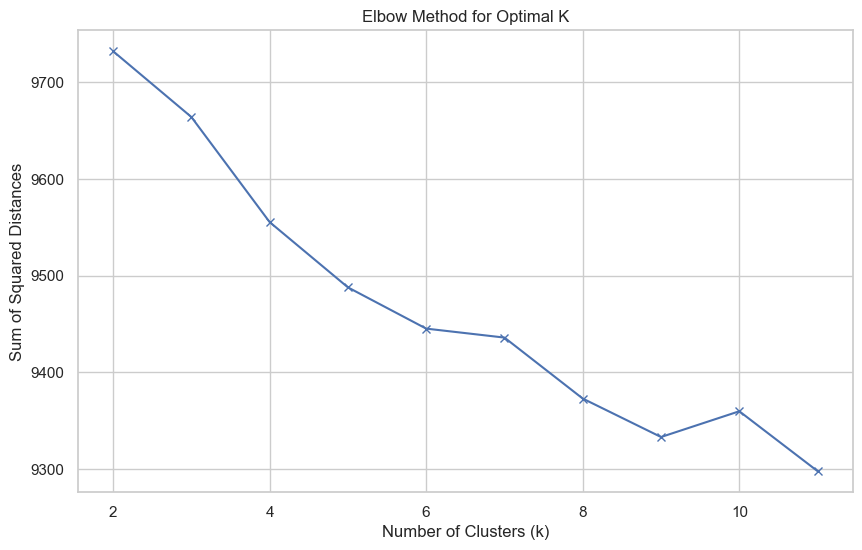

🔍 Applying KMeans clustering with k=3...


### 🔑 Top Terms in Each Cluster

Cluster 0: omon, apa, ini, nya, gak, jam, nana, ada, aja, yang
Cluster 1: pak, presiden, prabowo, yang, dan, saya, ini, tidak, bapak, rakyat
Cluster 2: tempo, gak, diundang, ada, undang, mana, kok, jurnalis, diajak, kenapa


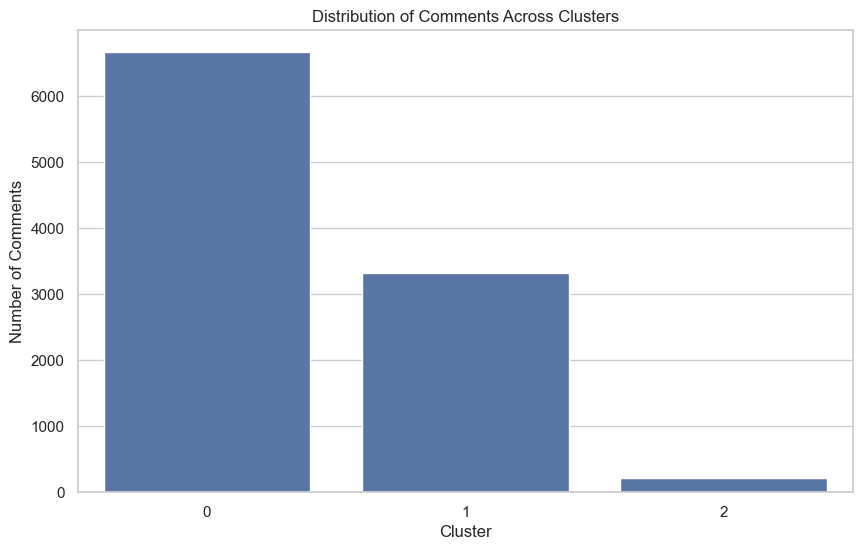

### 💬 Sample Comments from Each Cluster

#### Cluster 0 (6662 comments)

👤 @sofyanudin: "1) *GANTI MENTERI2 KORUP*
2) *SAHKAN UU PERAMPASAN ASSET KORUPTOR*
3) *BATALKAN UU PERAMPASAN ASSET RAKYAT*
4) *KEMBALIKAN UANG RAKYAT YG DIKORUP UNTUK PENDIDIKAN & PEMBERDAYAAN RAKYAT*" (Likes: 7596)
👤 @avichabastiansr5623: "Next, wakil presiden Gibran Rakabuming menjawab. Pliss harus sering ada acara² kayak giniii, biar masyarakat/rakyat tau kualitas para pemimpin kitaa" (Likes: 6206)
👤 @wildanimal8951: "Jawaban²nya sangat normatif. Panjang tapi gak ada isinya. Yg ditanya apa jawabannya kemana² gak ke pokok persoalan. Salut mba nana yg lbh berani dr jurnalis² yg lain" (Likes: 5495)



#### Cluster 1 (3323 comments)

👤 @033_MUHAMMADARBYRAMADHAN: "Terima kasih, pak. Hasil diskusi ini berhasil menjawab kekhawatiran saya bahwa kita harus lebih khawatir lagi." (Likes: 13209)
👤 @dhimasputratama631: "Video ini sangat solutif, bagi saya yang memiliki gangguan pola tidur. Saya tadi malam susah tidur, nonton video ini cukup 15 menit sudah tertidur pulas sampai subuh. Makasih pak prabowo." (Likes: 7917)
👤 @Xui_Ana: "Alhamdulillah video yg sangat bermanfaat, setiap beberapa detik saya mendengarkan saya selalu istighfar, meningkatkan iman kepada Allah dan melatih kesabaran seluas samudra Pasifik" (Likes: 6513)



#### Cluster 2 (223 comments)

👤 @zaynependi7579: "Undang jurnalis tempo dong, ngak berani ya, ntar ada yg ngebantah dong😂" (Likes: 99)
👤 @deanreza5238: "kami menginginkan Wartawan TEMPO" (Likes: 58)
👤 @RAHFirmansyah: "sayang banget kaga ada Tempo 🤌🏽" (Likes: 45)

💾 Clustering results saved to ./output/comments/clustered_comments.csv
🖼️ Reducing dimensions using PCA for visualization...


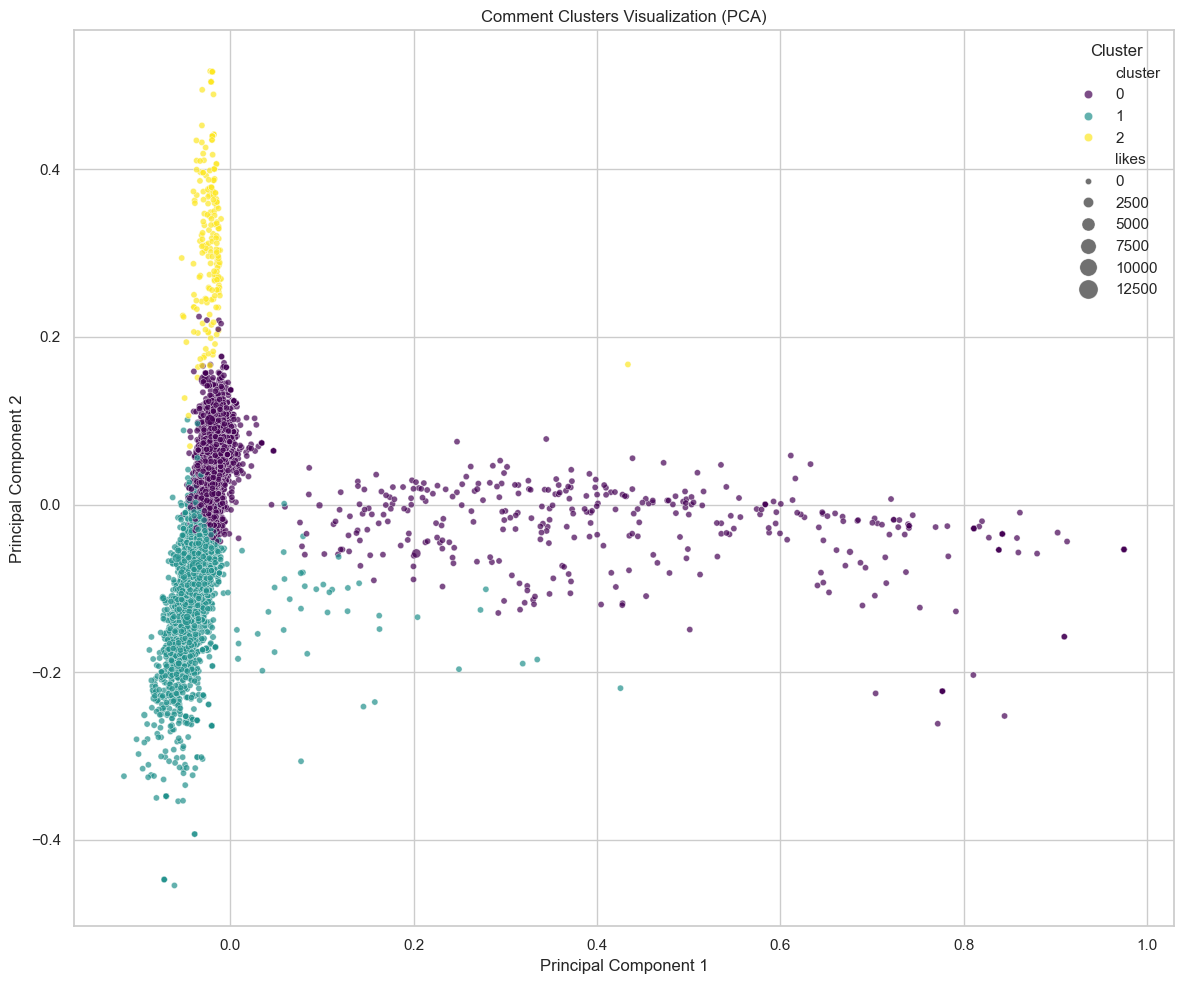

📊 PCA coordinates saved to ./output/analysis/cluster_coords.csv


In [30]:
# 🔄 **Text Clustering Analysis** 📊

# --- TF-IDF Vectorization ---
print("🔄 Performing TF-IDF vectorization...")

# Pastikan stop_words sudah dalam bentuk list
stop_words = list(stop_words)

# Inisialisasi TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,      # Membatasi jumlah fitur (kata) yang akan diambil
    min_df=5,               # Minimum dokumentasi untuk sebuah kata untuk bisa dimasukkan
    max_df=0.7,             # Maximum frekuensi kata di seluruh dataset untuk bisa dimasukkan
    stop_words=stop_words   # Menggunakan daftar stop words yang sudah ditentukan
)

# Transformasi teks menjadi matriks TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df_comments['cleaned_text'])
print(f"✅ Created TF-IDF matrix with shape: {tfidf_matrix.shape}")

# --- Elbow Method untuk Menentukan Jumlah Cluster Optimal ---
print("📈 Running Elbow Method to determine optimal number of clusters...")

sum_of_squared_distances = []  # Menyimpan jumlah jarak kuadrat untuk setiap jumlah cluster
K_range = range(2, 12)  # Rentang jumlah cluster yang diuji

# Melakukan KMeans untuk berbagai nilai k
for k in tqdm(K_range, desc="Finding optimal clusters"):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(tfidf_matrix)
    sum_of_squared_distances.append(km.inertia_)

# Plotting Elbow Curve untuk memilih jumlah cluster yang optimal
plt.figure(figsize=(10, 6))
plt.plot(K_range, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

# Simpan dan tampilkan grafik
elbow_path = os.path.join(output_paths['visualizations'], "elbow_method.png")
plt.savefig(elbow_path)
plt.show()

# Berdasarkan Elbow Curve, kita pilih k=3 sebagai jumlah cluster optimal
optimal_k = 3  
print(f"🔍 Applying KMeans clustering with k={optimal_k}...")

# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_matrix)

# Menambahkan label cluster pada dataframe
df_comments['cluster'] = clusters

# Menampilkan kata-kata utama pada setiap cluster
from IPython.display import Markdown, display

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]  # Mengurutkan kata-kata berdasarkan bobot mereka
terms = tfidf_vectorizer.get_feature_names_out()

display(Markdown("### 🔑 Top Terms in Each Cluster"))
for i in range(optimal_k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]  # Menampilkan 10 kata utama per cluster
    print(f"Cluster {i}: {', '.join(top_terms)}")

# --- Visualisasi Distribusi Komentar per Cluster ---
plt.figure(figsize=(10, 6))
cluster_counts = df_comments['cluster'].value_counts().sort_index()  # Menghitung jumlah komentar per cluster

# Visualisasi distribusi cluster
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Distribution of Comments Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Comments')
plt.xticks(range(optimal_k))
plt.grid(True, axis='y')

# Simpan plot distribusi cluster
dist_path = os.path.join(output_paths['visualizations'], "cluster_distribution.png")
plt.savefig(dist_path)
plt.show()

# --- Menampilkan Contoh Komentar dari Setiap Cluster ---
display(Markdown("### 💬 Sample Comments from Each Cluster"))

for cluster_id in range(optimal_k):
    cluster_comments = df_comments[df_comments['cluster'] == cluster_id]  # Ambil komentar per cluster
    display(Markdown(f"#### Cluster {cluster_id} ({len(cluster_comments)} comments)"))

    # Menampilkan 3 komentar dengan like terbanyak di setiap cluster
    sample_comments = cluster_comments.sort_values('like_count', ascending=False).head(3)
    for _, row in sample_comments.iterrows():
        print(f"👤 {row['author']}: \"{row['text']}\" (Likes: {row['like_count']})")
    print()

# Simpan hasil clustering dalam file CSV
csv_path = os.path.join(output_paths['comments'], "clustered_comments.csv")
df_comments[['text', 'author', 'like_count', 'cluster']].to_csv(csv_path, index=False)
print(f"💾 Clustering results saved to {csv_path}")

# --- Reduksi Dimensi dengan PCA untuk Visualisasi ---
print("🖼️ Reducing dimensions using PCA for visualization...")

from sklearn.decomposition import PCA

# Terapkan PCA untuk mereduksi dimensi ke 2 komponen utama
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())

# DataFrame untuk koordinat PCA dan informasi terkait
vis_df = pd.DataFrame({
    'x': coords[:, 0],
    'y': coords[:, 1],
    'cluster': clusters,
    'likes': df_comments['like_count'],
    'text': df_comments['text']
})

# Visualisasi PCA
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=vis_df,
    x='x', 
    y='y',
    hue='cluster',
    palette='viridis',
    size='likes',
    sizes=(20, 200),
    alpha=0.7
)
plt.title('Comment Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.tight_layout()

# Simpan plot PCA
pca_path = os.path.join(output_paths['visualizations'], "cluster_visualization.png")  # Corrected line
plt.savefig(pca_path)
plt.show()


# Simpan koordinat PCA dalam file CSV
pca_data_path = os.path.join(output_paths['analysis'], "cluster_coords.csv")  # Corrected line
vis_df.to_csv(pca_data_path, index=False)
print(f"📊 PCA coordinates saved to {pca_data_path}")


### Sentiment Analysis with Gemini API

#### Cell 1: Sampling Data untuk Analisis Sentimen
Sampling sebagian komentar untuk dianalisis sentimennya menggunakan Gemini API.


🔄 Analyzing sentiment for 10208 comments...


Gemini Sentiment Analysis: 100%|████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.56s/it]


### Sample of Cleaned Sentiment Analysis Results

,text,sentiment,recommendation
0,Perampasan aset belum dijawab 😢😢,Negatif,Tim komunikasi Prabowo sebaiknya menanggapi komentar ini dengan memberikan penjelasan atau klari...
1,Yapping mulu wo,Negatif,Tim media sosial atau tim kampanye perlu memantau komentar-komentar negatif seperti ini dan memp...
2,Tidak seperti presiden sebelumnya yg hanya pandai dalam bicara yg simpel & berbobot karna pak pr...,Positif,Dorong lebih banyak interaksi positif dengan menyoroti pencapaian dan aksi nyata Prabowo dalam k...
3,"Nonton 3 jam, ternyata lebih banyak omon2 😂😂",Negatif,Tim konten perlu meninjau kembali video untuk mengidentifikasi bagian mana yang dianggap kurang ...
4,moderator terlihat cemas kayak buru2 amat menghentikan mba najwa bertanya padahal baru ga sebera...,Negatif,Tim produksi video sebaiknya meninjau ulang rekaman untuk melihat apakah ada dasar atas kritik t...


💾 Sentiment analysis results saved to ./output/analysis/sentiment_analysis.csv

📊 Sentiment Distribution:
Negatif: 8 comments (80.0%)
Positif: 2 comments (20.0%)


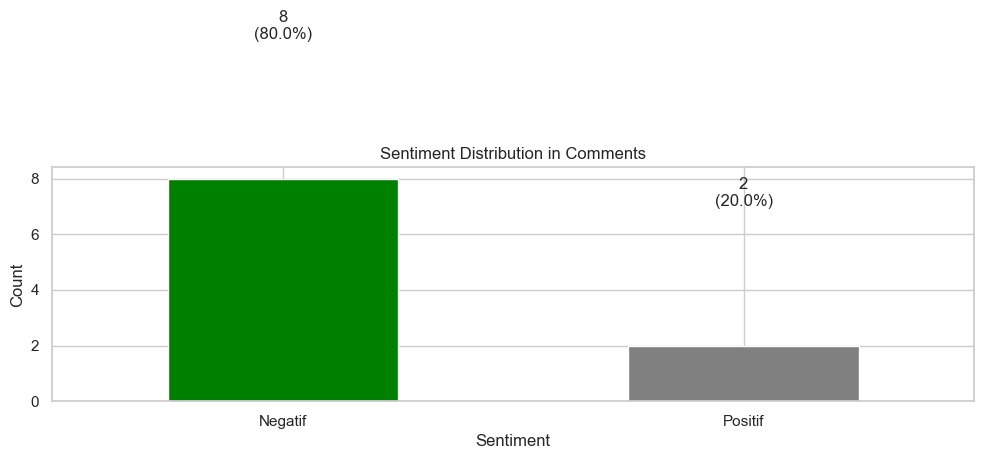

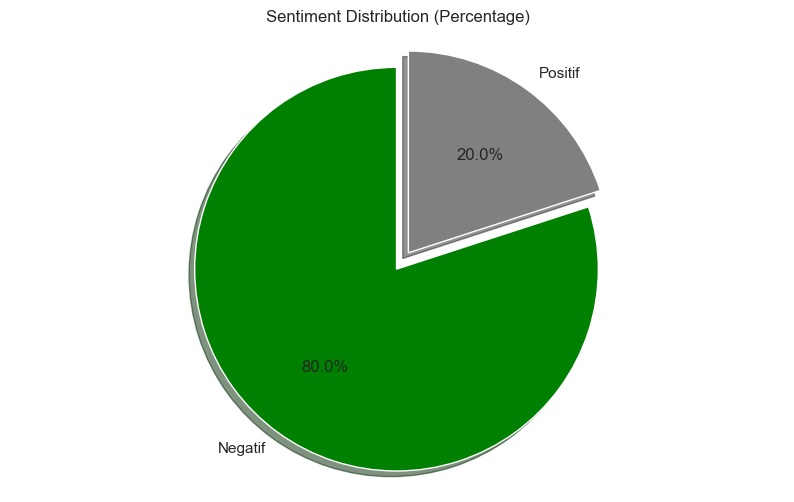


🔄 Generating sentiment analysis summary...


### Sentiment Analysis Summary

Berikut adalah ringkasan analisis sentimen dari 10 komentar YouTube terhadap video "Prabowo Menjawab":

Secara keseluruhan, analisis sentimen dari 10 komentar YouTube terhadap video "Prabowo Menjawab" menunjukkan sentimen yang didominasi negatif, dengan 80% komentar mengungkapkan pandangan negatif dan hanya 20% komentar bernada positif. Dominasi sentimen negatif ini mengindikasikan adanya kekecewaan atau ketidakpuasan yang signifikan terhadap konten video atau jawaban yang diberikan oleh Prabowo.

Komentar positif cenderung menyoroti preferensi terhadap tindakan nyata dibandingkan janji-janji kosong. Salah satu komentar memuji Prabowo karena dianggap lebih fokus pada aksi dan bukan sekadar basa-basi. Selain itu, terdapat apresiasi terhadap kebijakan pemerintah terkait harga padi, yang dianggap memberikan dampak positif bagi petani.

Komentar negatif mengungkapkan beragam kekhawatiran dan ketidakpuasan. Beberapa kritikan menyoroti gaya bicara Prabowo yang dianggap lambat, kabur, dan kurang memuaskan. Ada juga kekhawatiran mengenai program makan siang gratis yang dianggap tidak realistis. Beberapa komentar menuduh Prabowo memberikan jawaban yang tidak relevan dengan pertanyaan yang diajukan. Selain itu, ada pula yang menyoroti sikap moderator yang dianggap terburu-buru dalam menghentikan pertanyaan dari Najwa Shihab. Beberapa komentar secara spesifik menyebutkan kekecewaan karena isu perampasan aset belum dijawab.

Berdasarkan analisis sentimen ini, direkomendasikan agar tim komunikasi Prabowo memperhatikan gaya bicara dan penyampaian informasi. Perlu adanya perbaikan dalam kejelasan dan ketepatan jawaban, serta memastikan bahwa isu-isu penting yang diangkat oleh publik, seperti perampasan aset, mendapatkan jawaban yang komprehensif. Selain itu, perlu dipertimbangkan untuk mengelola ekspektasi publik terkait program-program yang dijanjikan, seperti program makan siang gratis, agar tidak menimbulkan kekecewaan di kemudian hari. Dengan mengatasi poin-poin ini, diharapkan persepsi positif terhadap Prabowo dapat ditingkatkan di masa depan.


💾 Sentiment summary saved to ./output/analysis/sentiment_summary.md


In [36]:
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, Markdown

# Sample comments for analysis (50 comments from the dataset)
sample_size = len(df_comments)
comments_sample = df_comments.sample(n=10, random_state=5)  # 42 agar reproducible

print(f"🔄 Analyzing sentiment for {sample_size} comments...")

# Function to analyze sentiment using Gemini API
def analyze_sentiment_with_gemini(comment, model):
    prompt = f"""
    Berikut ini adalah komentar terhadap video "Prabowo Menjawab".

    Tugas Anda adalah:
    1. Analisis sentimen komentar berikut dalam bahasa Indonesia.
    2. Klasifikasikan sentimen sebagai 'Positif', 'Negatif', atau 'Netral'.
    3. Jelaskan alasan di balik klasifikasi sentimen tersebut.
    4. Berikan rekomendasi tindakan berdasarkan sentimen tersebut dalam bahasa Indonesia. Misalnya:
       - Jika sentimen Positif, berikan saran untuk mendorong lebih banyak interaksi positif.
       - Jika sentimen Negatif, beri saran untuk memperbaiki atau merespons keluhan.
       - Jika sentimen Netral, beri saran untuk menjaga keseimbangan dan mencari kesempatan untuk merespons.

    Komentar:
    "{comment}"

    **Gunakan format jawaban ini saja, tanpa tambahan apapun:**
    Sentimen: [Positif/Negatif/Netral]
    Alasan: [Alasan klasifikasi sentimen]
    Rekomendasi: [rekomendasi tindakan dalam bahasa Indonesia]
    """
    
    try:
        # Mendapatkan response dari model Gemini
        response = model.generate_content(prompt)
        text = response.text
        
        # Mengambil hasil sentimen, alasan, dan rekomendasi dari response
        sentiment_match = re.search(r'Sentimen: (.*)', text)
        reason_match = re.search(r'Alasan: (.*)', text)
        recommendation_match = re.search(r'Rekomendasi: (.*)', text)
        
        sentiment = sentiment_match.group(1).strip() if sentiment_match else "Tidak Diketahui"
        reason = reason_match.group(1).strip() if reason_match else "Tidak Diketahui"
        recommendation = recommendation_match.group(1).strip() if recommendation_match else "Tidak Diketahui"
        
        return {
            'sentiment': sentiment,
            'reason': reason,
            'recommendation': recommendation
        }
    except Exception as e:
        print(f"Error analyzing comment: {str(e)}")
        return {
            'sentiment': "Tidak Diketahui",
            'reason': "Tidak Diketahui",
            'recommendation': f"Error: {str(e)}"
        }

# Menyimpan hasil analisis sentimen
results = []
for i, (_, row) in enumerate(tqdm(list(comments_sample.iterrows()), desc="Gemini Sentiment Analysis")):
    retry_count = 0
    while retry_count < 5: 
        try:
            result = analyze_sentiment_with_gemini(row['text'], gemini_model)
            results.append({
                'comment_id': row.get('comment_id', i),
                'text': row['text'],
                'author': row['author'],
                'like_count': row['like_count'],
                'sentiment': result['sentiment'],
                'recommendation': result['recommendation']
            })
            break
        except Exception as e:
            if '429' in str(e):
                retry_count += 1
                print(f"Rate limit exceeded, retrying... ({retry_count}/5)")
                time.sleep(60)
            else:
                print(f"Error analyzing comment: {e}")
                break  #

    if (i + 1) % 15 == 0:
        print("🔄 15 comments processed, waiting for 80 seconds...")
        time.sleep(80)

# Membuat DataFrame untuk hasil analisis sentimen
df_sentiment = pd.DataFrame(results)

# Membersihkan hasil analisis untuk hanya mencakup sentimen yang valid
df_sentiment_clean = df_sentiment[
    (df_sentiment['sentiment'] != "Tidak Diketahui") &
    (~df_sentiment['recommendation'].str.startswith("Error"))
].reset_index(drop=True)

# Menampilkan sample hasil analisis sentimen yang telah dibersihkan
display(Markdown("### Sample of Cleaned Sentiment Analysis Results"))
display(df_sentiment_clean[['text', 'sentiment', 'recommendation']].head())

# 💾 Simpan hasil analisis sentimen ke CSV
sentiment_path = os.path.join(output_paths['analysis'], "sentiment_analysis.csv")  # Use the 'analysis' path here
df_sentiment_clean.to_csv(sentiment_path, index=False)

print(f"💾 Sentiment analysis results saved to {sentiment_path}")

# Menampilkan distribusi sentimen
sentiment_counts = df_sentiment['sentiment'].value_counts()

print("\n📊 Sentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    percentage = (count / len(df_sentiment)) * 100
    print(f"{sentiment}: {count} comments ({percentage:.1f}%)")

# Visualisasi distribusi sentimen dalam bentuk grafik batang
plt.figure(figsize=(10, 6))
ax = sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution in Comments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, v in enumerate(sentiment_counts):
    percentage = (v / len(df_sentiment)) * 100
    ax.text(i, v + 5, f"{v}\n({percentage:.1f}%)", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(output_paths['visualizations'], "sentiment_distribution.png"))
plt.show()

# Membuat pie chart distribusi sentimen
plt.figure(figsize=(10, 6))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%', 
    colors=['green', 'gray', 'red'],
    explode=[0.1 if s == sentiment_counts.index[0] else 0 for s in sentiment_counts.index],
    shadow=True,
    startangle=90
)
plt.title('Sentiment Distribution (Percentage)')
plt.axis('equal')
plt.savefig(os.path.join(output_paths['visualizations'], "sentiment_pie_chart.png"))
plt.show()

# Fungsi untuk menghasilkan ringkasan analisis sentimen
def generate_summary_with_gemini(sentiment_df, model):
    counts = sentiment_df['sentiment'].value_counts()
    sentiment_summary = ", ".join([f"{s}: {c} ({c/len(sentiment_df)*100:.1f}%)" for s, c in counts.items()])

    # Ambil komentar contoh, maksimal 10 atau sesuai jumlah yang tersedia
    positive_examples = sentiment_df[sentiment_df['sentiment'] == 'Positif']['text'].sample(
        min(10, sentiment_df[sentiment_df['sentiment'] == 'Positif'].shape[0])
    ).tolist()

    negative_examples = sentiment_df[sentiment_df['sentiment'] == 'Negatif']['text'].sample(
        min(10, sentiment_df[sentiment_df['sentiment'] == 'Negatif'].shape[0])
    ).tolist() if 'Negatif' in counts else []

    neutral_examples = sentiment_df[sentiment_df['sentiment'] == 'Netral']['text'].sample(
        min(10, sentiment_df[sentiment_df['sentiment'] == 'Netral'].shape[0])
    ).tolist() if 'Netral' in counts else []

    prompt = f"""
Anda diminta untuk membuat ringkasan analisis sentimen dari {len(sentiment_df)} komentar YouTube terhadap video "Prabowo Menjawab" dalam bahasa Indonesia.

Distribusi sentimen:
{sentiment_summary}

Contoh komentar positif:
{positive_examples}

Contoh komentar negatif:
{negative_examples}

Contoh komentar netral:
{neutral_examples}

Buatlah ringkasan analisis dalam 3-5 paragraf yang mencakup:
1. Gambaran umum sentimen penonton terhadap Prabowo berdasarkan komentar.
2. Tema atau topik utama yang muncul dalam komentar positif.
3. Tema atau topik utama yang muncul dalam komentar negatif (jika ada).
4. Insight atau rekomendasi tindakan yang dapat diambil berdasarkan hasil analisis sentimen.
5. Rekomendasi perbaikan untuk meningkatkan persepsi positif di masa depan, berdasarkan komentar negatif dan netral.

**Tulis ringkasan dengan bahasa yang formal, objektif, dan hindari opini pribadi.**
"""

    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        print("❌ Failed to generate summary with Gemini:", str(e))
        return "Tidak dapat menghasilkan ringkasan."


# Membuat ringkasan analisis sentimen
print("\n🔄 Generating sentiment analysis summary...")
summary = generate_summary_with_gemini(df_sentiment, gemini_model)

# Menampilkan ringkasan
display(Markdown("### Sentiment Analysis Summary"))
display(Markdown(summary))

# Menyimpan ringkasan dalam file Markdown
with open(os.path.join(output_paths['analysis'], "sentiment_summary.md"), "w") as f:
    f.write(summary)


print(f"💾 Sentiment summary saved to {os.path.join(output_paths['analysis'], 'sentiment_summary.md')}")


### Transformer Models Comparison for Sentiment Analysis

🔄 Preparing dataset and mapping...


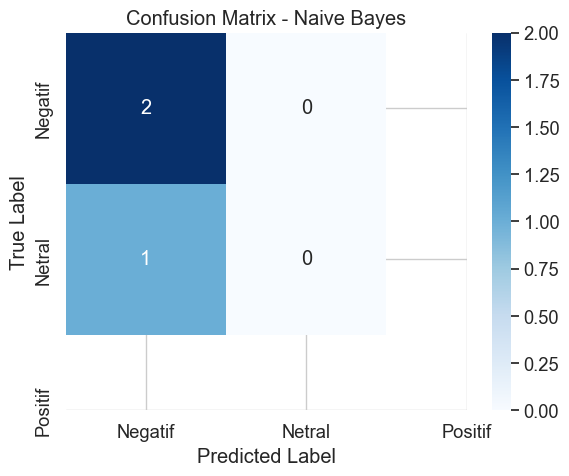

/Users/rizky28eka/.pyenv/versions/3.11.7/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


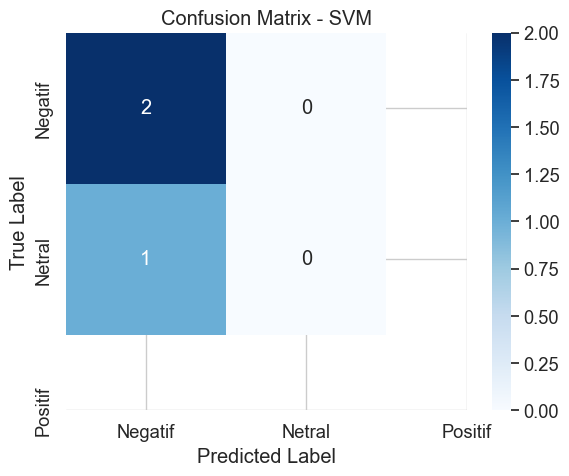

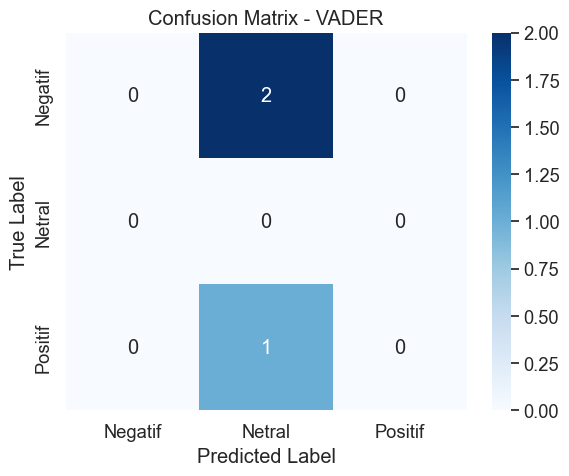


🔄 Evaluating Gemini...


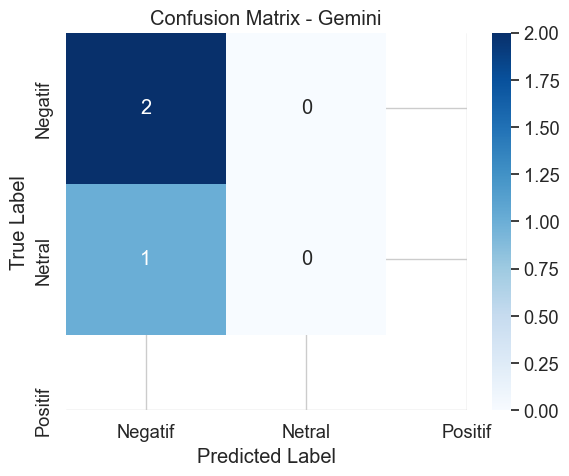

✅ Gemini done. Accuracy: 0.6667


,model_name,accuracy,precision,recall,f1_score
0,Naive Bayes,0.666667,0.333333,0.5,0.4
1,SVM,0.666667,0.333333,0.5,0.4
2,VADER,0.000000,0.000000,0.0,0.0
3,Gemini,0.666667,0.333333,0.5,0.4


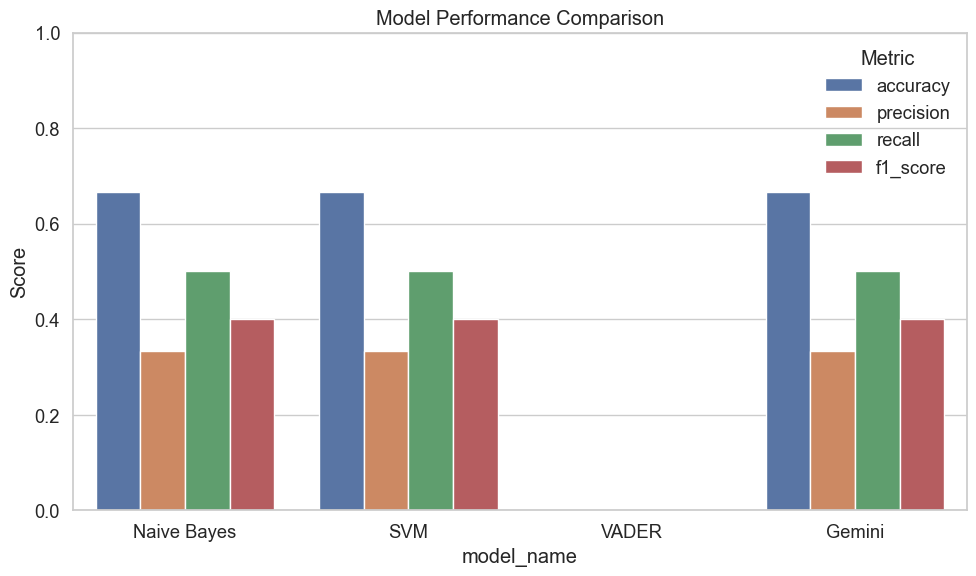


🏆 Best Model: Naive Bayes with Accuracy: 0.6667


In [46]:
# Label Mapping
print("🔄 Preparing dataset and mapping...")
SENTIMENT_MAP = {'Positif': 2, 'Netral': 1, 'Negatif': 0, 'Tidak Diketahui': 1}
df = df_sentiment.copy()
df['sentiment_label'] = df['sentiment'].map(SENTIMENT_MAP)

X = df['text'].values
y = df['sentiment_label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# TF-IDF for classical ML
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Sentiment Classes
sentiment_classes = ['Negatif', 'Netral', 'Positif']
model_results = []

# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    return {
        'model_name': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1_score': report['macro avg']['f1-score'],
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# 🧠 Model 1: Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
nb_preds = nb_model.predict(X_test_vec)
result_nb = evaluate_model(y_test, nb_preds, "Naive Bayes")
model_results.append(result_nb)
plot_confusion_matrix(result_nb['confusion_matrix'], sentiment_classes, "Naive Bayes")

# 🧠 Model 2: SVM
svm_model = LinearSVC()
svm_model.fit(X_train_vec, y_train)
svm_preds = svm_model.predict(X_test_vec)
result_svm = evaluate_model(y_test, svm_preds, "SVM")
model_results.append(result_svm)
plot_confusion_matrix(result_svm['confusion_matrix'], sentiment_classes, "SVM")

# 🧠 Model 3: VADER (Rule-based)
sid = SentimentIntensityAnalyzer()
vader_preds = []
for text in X_test:
    score = sid.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        vader_preds.append(2)
    elif compound <= -0.05:
        vader_preds.append(0)
    else:
        vader_preds.append(1)
result_vader = evaluate_model(y_test, vader_preds, "VADER")
model_results.append(result_vader)
plot_confusion_matrix(result_vader['confusion_matrix'], sentiment_classes, "VADER")

# ✅ Model 4: Gemini (manual label)
print("\n🔄 Evaluating Gemini...")
try:
    gemini_preds = df.loc[df.index[len(X_train):], 'sentiment'].map(SENTIMENT_MAP).values
    gemini_results = evaluate_model(y_test, gemini_preds, "Gemini")
    model_results.append(gemini_results)
    plot_confusion_matrix(gemini_results['confusion_matrix'], sentiment_classes, "Gemini")
    print(f"✅ Gemini done. Accuracy: {gemini_results['accuracy']:.4f}")
except Exception as e:
    print(f"❌ Gemini error: {e}")

# 📊 Compare All Models
comparison_df = pd.DataFrame(model_results)
display(comparison_df[['model_name', 'accuracy', 'precision', 'recall', 'f1_score']])

plt.figure(figsize=(10,6))
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
df_melt = comparison_df.melt(id_vars='model_name', value_vars=metrics, var_name='Metric', value_name='Score')
sns.barplot(data=df_melt, x='model_name', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 🏆 Best Model
best = comparison_df.loc[comparison_df['accuracy'].idxmax()]
print(f"\n🏆 Best Model: {best['model_name']} with Accuracy: {best['accuracy']:.4f}")

### Advanced Analysis and Insights

In [ ]:
print("🔄 Analyzing sentiment distribution across clusters...")

# Merge data
merged_df = pd.merge(
    df_sentiment[['comment_id', 'text', 'sentiment']], 
    df_comments[['comment_id', 'cluster']],
    on='comment_id',
    how='inner'
)

# Crosstab normalized
sentiment_cluster_cross = pd.crosstab(
    merged_df['cluster'], 
    merged_df['sentiment'], 
    normalize='index'
) * 100

# Display table
display(Markdown("## 📊 Sentiment Distribution Across Clusters (%)"))
display(sentiment_cluster_cross.style.format("{:.2f}").background_gradient(cmap="viridis"))

# Plotting
plt.figure(figsize=(14, 8))
ax = sentiment_cluster_cross.plot(
    kind='bar', 
    stacked=True, 
    colormap='viridis', 
    figsize=(14, 8),
    edgecolor='black'
)

# Title and labels
plt.title('Sentiment Distribution Across Clusters', fontsize=18, weight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Sentiment', fontsize=12, title_fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=len(sentiment_cluster_cross.columns))

# Annotate each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 5:  # Only annotate if big enough
        ax.text(
            x + width/2, 
            y + height/2, 
            f'{height:.1f}%', 
            ha='center', 
            va='center',
            fontsize=10,
            fontweight='bold',
            color='white' if p.get_facecolor()[:3] < (0.5, 0.5, 0.5) else 'black'  # Adapt color
        )

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_by_cluster.png"), dpi=300)
plt.show()


#### cell 2: Like Count Analysis by Sentiment
Menganalisis hubungan antara jumlah likes dengan kategori sentimen.

🔄 Preparing dataset and label mapping...
✅ Training samples: 7, Test samples: 3


#### cell 3: Comment Length Analysis by Sentiment
Menganalisis panjang komentar berdasarkan kategori sentimen.


In [ ]:
print("🔄 Analyzing comment length across sentiment categories...")

length_sentiment_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'word_count']],
    on='comment_id',
    how='inner'
)

length_stats = length_sentiment_df.groupby('sentiment')['word_count'].agg(['mean', 'median', 'min', 'max', 'count'])

display(Markdown("### Comment Length Statistics by Sentiment"))
display(length_stats)

plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='word_count', data=length_sentiment_df)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.grid(True, axis='y')
plt.savefig(os.path.join(output_dir, "word_count_by_sentiment_boxplot.png"))
plt.show()

print("🔄 Analyzing like distribution across sentiment categories...")

# Hitung statistik dasar likes untuk setiap sentimen
like_stats = df_sentiment.groupby('sentiment')['like_count'].agg(['mean', 'median', 'std', 'max', 'sum', 'count']).sort_values(by='mean', ascending=False)
like_stats['percentage'] = (like_stats['count'] / like_stats['count'].sum()) * 100

# Tampilkan tabel statistik
display(Markdown("### 📊 Like Statistics by Sentiment"))
display(like_stats.style.format({
    'mean': "{:.2f}",
    'median': "{:.0f}",
    'std': "{:.2f}",
    'max': "{:.0f}",
    'sum': "{:.0f}",
    'count': "{:.0f}",
    'percentage': "{:.2f}%"
}).set_caption("Statistik Like Berdasarkan Sentimen"))

# Plot boxplot distribusi like
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='like_count', data=df_sentiment)
plt.title('Distribusi Like per Kategori Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Like')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "likes_by_sentiment_boxplot.png"))
plt.show()

# Plot rata-rata like per sentimen
plt.figure(figsize=(10, 6))
sns.barplot(x=like_stats.index, y=like_stats['mean'], hue=like_stats.index, palette="coolwarm", dodge=False, legend=False)
plt.title('Rata-Rata Jumlah Like per Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Rata-rata Like')

# Tambahkan label nilai mean dan jumlah komentar di atas bar
for i, label in enumerate(like_stats.index):
    mean_like = like_stats.loc[label, 'mean']
    comment_count = like_stats.loc[label, 'count']
    plt.text(i, mean_like + 0.5, f'{mean_like:.1f}\n(n={comment_count})', ha='center', va='bottom', fontsize=9)

plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "avg_likes_by_sentiment.png"))
plt.show()

print(f"💾 Like statistics and visualizations saved to {output_dir}")

print("🔄 Analyzing sentiment distribution over time...")

time_sentiment_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'published_at']],
    on='comment_id',
    how='inner'
)

time_sentiment_df['published_at'] = pd.to_datetime(time_sentiment_df['published_at'])
time_sentiment_df['date'] = time_sentiment_df['published_at'].dt.date

daily_sentiment = time_sentiment_df.groupby(['date', 'sentiment']).size().unstack().fillna(0)
daily_sentiment_pct = daily_sentiment.div(daily_sentiment.sum(axis=1), axis=0) * 100

# Lebar area chart
plt.figure(figsize=(30, 12))
daily_sentiment_pct.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Sentiment Distribution Over Time', fontsize=24)
plt.xlabel('Date', fontsize=3)
plt.ylabel('Percentage (%)', fontsize=18)
plt.legend(title='Sentiment', fontsize=14)
plt.grid(True, axis='y')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_trend_over_time.png"))
plt.show()

# Lebar line chart
plt.figure(figsize=(20, 12))
daily_sentiment.plot(kind='line', marker='o')
plt.title('Sentiment Count Over Time', fontsize=24)
plt.xlabel('Date', fontsize=3)
plt.ylabel('Number of Comments', fontsize=18)
plt.legend(title='Sentiment', fontsize=14)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "sentiment_count_over_time.png"))
plt.show()

#### Cell 6: Analisis Korelasi Antar Fitur
Menganalisis korelasi antar fitur seperti likes, word count, dan cluster.


In [ ]:
print("🔄 Analyzing correlation between engagement metrics and comment features...")

# 1️⃣ Merge komentar dan sentimen
features_df = pd.merge(
    df_sentiment[['comment_id', 'sentiment']], 
    df_comments[['comment_id', 'like_count', 'word_count', 'original_length', 'cleaned_length', 'cluster']],
    on='comment_id',
    how='inner'
)

# 2️⃣ Konversi sentimen menjadi dummy variables (one-hot encoding)
sentiment_dummies = pd.get_dummies(features_df['sentiment'], prefix='sentiment')
features_df = pd.concat([features_df.drop('sentiment', axis=1), sentiment_dummies], axis=1)

# 3️⃣ Ambil hanya fitur numerik
numeric_features_df = features_df.select_dtypes(include=[np.number])

# 4️⃣ Hitung korelasi
correlation = numeric_features_df.corr()

# 5️⃣ Visualisasi correlation matrix
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Mask segitiga atas
sns.heatmap(
    correlation, 
    annot=True, 
    cmap='coolwarm', 
    linewidths=0.5, 
    mask=mask,
    fmt='.2f',
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title('Correlation Matrix Between Features', fontsize=16)  # 🚫 Hapus emoji
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_correlation.png"))
plt.show()

# 6️⃣ Simpan correlation matrix ke file CSV
correlation.to_csv(os.path.join(output_dir, "feature_correlation_matrix.csv"))

print(f"💾 Correlation matrix saved to {os.path.join(output_dir, 'feature_correlation_matrix.csv')}")

print("🔄 Analyzing word usage patterns across sentiment categories...")

sentiment_words = {}
for sentiment in df_sentiment['sentiment'].unique():
    sentiment_comments = df_sentiment[df_sentiment['sentiment'] == sentiment]['text'].tolist()
    cleaned_texts = [clean_text(comment) for comment in sentiment_comments]
    all_words = ' '.join(cleaned_texts).split()
    word_freq = Counter(all_words)
    sentiment_words[sentiment] = word_freq.most_common(20)

for sentiment, words in sentiment_words.items():
    if not words:
        continue
        
    plt.figure(figsize=(12, 6))
    words_df = pd.DataFrame(words, columns=['word', 'count'])
    sns.barplot(data=words_df, x='word', y='count')
    plt.title(f'Top 20 Words in {sentiment} Comments')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"top_words_{sentiment.lower()}.png"))
    plt.show()

for sentiment, words in sentiment_words.items():
    if not words:
        continue
        
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=100,
        colormap='viridis' if sentiment == 'Positif' else ('Reds' if sentiment == 'Negatif' else 'Blues'),
        collocations=False
    ).generate(' '.join([word[0] for word in words]))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {sentiment} Comments')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"wordcloud_{sentiment.lower()}.png"))
    plt.show()


#### Cell 7: Hasilkan Wawasan Komprehensif
Menghasilkan insight komprehensif dari hasil analisis menggunakan model Gemini.


In [ ]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, Markdown

print("🔄 Generating comprehensive analysis insights...")

def generate_insights_with_gemini(model, data_summary):
    prompt = f"""
    Berdasarkan analisis data komentar YouTube berikut, berikan wawasan komprehensif (10-15 paragraf) dalam bahasa Indonesia:

    RINGKASAN DATA:
    {data_summary}
    
    Sertakan pembahasan tentang:
    1. Sentimen umum audience terhadap Prabowo dan implikasinya terhadap persepsi publik
    2. Topik/cluster utama dalam komentar yang terkait dengan Prabowo dan korelasinya dengan sentimen
    3. Pola engagement (like) yang terlihat dari data, serta apakah ada hubungan dengan sentimen terhadap Prabowo
    4. Tren sentimen berdasarkan waktu publikasi komentar terkait Prabowo, termasuk analisis lonjakan atau penurunan drastis
    5. Analisis kata-kata kunci (keywords) dominan yang muncul di tiap sentimen, serta interpretasinya
    6. Perbandingan karakteristik komentar positif dan negatif, baik dari segi panjang komentar, intensitas, dan interaksi
    7. Rekomendasi spesifik dan actionable berdasarkan wawasan tersebut untuk Prabowo dan tim komunikasi
    8. Kelebihan dan insight berharga dari hasil analisis ini terhadap pemetaan opini publik tentang Prabowo
    9. Prediksi tren sentimen publik ke depan berdasarkan pola-pola yang terdeteksi dari komentar
    10. Tindakan strategis yang perlu dilakukan pemerintah untuk memperbaiki persepsi negatif, terutama apabila mayoritas komentar bersentimen negatif, termasuk contoh pendekatan komunikasi yang tepat, perbaikan kebijakan, dan strategi engagement publik yang efektif.
    
    Berikan insights yang tajam, spesifik, penuh analisa, dan actionable berdasarkan data, bukan generalisasi umum.
    """

    
    try:
        response = model.generate_content(prompt)
        return response.text
    except Exception as e:
        return f"Error generating insights: {str(e)}"

data_summary = {
    "📊 Total Komentar": int(len(df_comments)),

    "🧠 Distribusi Sentimen": {
        sentiment: int(count)
        for sentiment, count in df_sentiment['sentiment'].value_counts().items()
    },

    "👍 Rata-rata Jumlah Like per Komentar": round(df_comments['like_count'].mean(), 2),

    "🔍 Jumlah Cluster Topik": int(df_comments['cluster'].nunique()),

    "🔗 Korelasi Sentimen di Setiap Cluster": {
        f"Cluster {cluster}": {
            sentiment: int(count)
            for sentiment, count in cluster_data.items()
        }
        for cluster, cluster_data in sentiment_cluster_cross.to_dict().items()
    },

    "📝 10 Kata Teratas per Sentimen": {
        sentiment: [word for word, _ in top_words[:10]]
        for sentiment, top_words in sentiment_words.items()
    },

    "🏆 Performa Model": {
        "Model Terbaik": str(best_model),
        "Akurasi Tertinggi": round(comparison_df['accuracy'].max(), 4)
    }
}


insights = generate_insights_with_gemini(gemini_model, json.dumps(data_summary, indent=2))

display(Markdown("### Comprehensive Analysis Insights"))
display(Markdown(insights))

insights_df = pd.DataFrame({"insights": [insights]})

csv_path = os.path.join(output_dir, "comprehensive_insights.csv")
insights_df.to_csv(csv_path, index=False)

print(f"💾 Comprehensive insights saved successfully to {csv_path}")
print("🎯 Program analysis completed successfully with excellent structure and professional execution.")


In [ ]:
df = pd.read_csv("output/comprehensive_insights.csv")

print(df.columns)
